In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import scipy.spatial.distance as dist
from navground import sim, core
from tslearn.generators import random_walks
from tslearn import metrics
import seaborn as sns
import gudhi
from gudhi.wasserstein import wasserstein_distance
from navground.sim.ui.video import display_video_from_run, record_video_from_run
from functools import partial
from IPython.display import Image

# Create folder to save bottleneck distances between matching diagrams
import os
os.makedirs("Corridor_matrices_consecutive", exist_ok=True)
os.makedirs("plots_consecutive", exist_ok=True)
title_1 = "Wasserstein distance"
title_2 = "sum matching difference"
title_3 = "wasserstein"

In [2]:
parser = argparse.ArgumentParser(description='Simulation Parameters')
parser.add_argument('--length', type=float, default=10.0, help='Length of the environment')
parser.add_argument('--width', type=float, default=10.0, help='Width of the environment')
parser.add_argument('--num_runs', type=int, default=1, help='Number of simulation runs')
parser.add_argument('--num_steps', type=int, default=100, help='Number of steps in the simulation')
parser.add_argument('--time_step', type=float, default=0.1, help='Time step for the simulation')
parser.add_argument('--num_agents', type=int, default=10, help='Number of agents in the simulation')
parser.add_argument('--max_speed', type=float, default=1.0, help='Maximum speed of agents')
parser.add_argument('--optimal_speed', type=float, default=1.0, help='Maximum speed of agents')
parser.add_argument('--radius', type=float, default=0.25, help='Radius of agents')
parser.add_argument('--safety_margin', type=float, default=0.1, help='Safety margin for agents')
parser.add_argument('--behavior', type=str, default='HL', help='Behavior type')
parser.add_argument('--max_edge_length', type=float, default=100.0, help='Maximum edge length in the simplicial complex')
parser.add_argument('--time_delay', type=int, default=1, help='Time delay to analise simulation intervals')
parser.add_argument('--embedding_length', type=int, default=10, help='Length of the simulation intervals')
parser.add_argument('--epsilon', type=int, default=50, help='time differences for matching and bottleneck distance computation')

_StoreAction(option_strings=['--epsilon'], dest='epsilon', nargs=None, const=None, default=50, type=<class 'int'>, choices=None, required=False, help='time differences for matching and bottleneck distance computation', metavar=None)

In [3]:
args = parser.parse_args([
        '--length', '18.0',
        '--width', '1.7',
        '--num_runs', '1',
        '--num_agents', '2',
        '--num_steps', '100',
        '--time_step', '0.1',
        '--max_speed', '1.66',
        '--optimal_speed', '1.2',
        '--radius', '0.4',
        '--safety_margin', '0.1',
        '--behavior', 'HL',
        '--max_edge_length', '50.0',
        '--time_delay', '2',
        '--embedding_length', '11',
        '--epsilon', '20',
    ])

In [4]:
yaml = f"""
runs: {args.num_runs}
steps: {args.num_steps}
time_step: {args.time_step}
save_directory: ''
record_pose: true
record_twist: true
record_collisions: true
record_deadlocks: true
scenario:
  bounding_box:
    min_x: 0
    max_x: {args.length}
    min_y: {-args.width/2}
    max_y: {args.width/2}
  walls:
    - line: [[{-1}, {-args.width/2}], [{args.length + 1}, {-args.width/2}]]
    - line: [[{-1}, {args.width/2}], [{args.length + 1}, {args.width/2}]]
  groups:
    -
      type: thymio
      number: 2
      radius: {args.radius}
      control_period: 0.1
      speed_tolerance: 0.02
      orientation: 0
      position: [[0, 0], [5, 0]]
      kinematics:
        type: 2WDiff
        wheel_axis: 0.094
        max_speed: {args.max_speed}
      behavior:
        type: {args.behavior}
        optimal_speed: {args.optimal_speed}
        horizon: 5.0
        safety_margin: {args.safety_margin}
      state_estimation:
        type: Bounded
        range: 5.0
      task:
        type: Direction
        direction: [1, 0]
    -
      type: thymio
      number: 1
      radius: {args.radius}
      control_period: 0.1
      speed_tolerance: 0.02
      orientation: 0
      position: [[4, 0]]
      kinematics:
        type: 2WDiff
        wheel_axis: 0.094
        max_speed: {args.max_speed*3/4}
      behavior:
        type: {args.behavior}
        optimal_speed: {args.optimal_speed*3/4}
        horizon: 5.0
        safety_margin: {args.safety_margin}
      state_estimation:
        type: Bounded
        range: 5.0
      task:
        type: Direction
        direction: [1, 0]
"""
experiment = sim.load_experiment(yaml)
experiment
experiment.run()
runs = experiment.runs

In [5]:
display_video_from_run(run=runs[0], factor=3.0, fps=10)

In [6]:
def normangle(angle):
    result = np.mod(angle, 2 * np.pi)
    result[result > np.pi] -= 2 * np.pi
    return result

In [7]:
def custom_distance(vector1, vector2, weights):
    result = 0
    if weights[0] != 0:
        px_diff = np.abs(vector1[0] - vector2[0])
        result += (px_diff * weights[0])**2
    if weights[1] != 0:
        py_diff = np.abs(vector1[1] - vector2[1])
        result += (py_diff * weights[1])**2
    if weights[2] != 0:
        pr_diff = np.abs(vector1[2] - vector2[2])
        pr_diff = np.minimum(pr_diff, 2 * np.pi - pr_diff)
        result += (pr_diff * weights[2])**2
    return np.sqrt(result)

In [38]:
weights = np.array([1,0.1,0.1])

In [39]:
custom_distance_with_param = partial(custom_distance, weights=weights)

In [40]:
import perdiver.perdiver as perdiver

def dismat_from_steps(trajectories, steps):
    num_agents = trajectories.shape[1]
    dismat = np.zeros((num_agents, num_agents))
    for a in range(num_agents):
        for b in range(a):
            _, tsim = metrics.dtw_path_from_metric(trajectories[steps,a,:], trajectories[steps,b,:], metric=custom_distance_with_param)
            dismat[a,b] = tsim
            dismat[b,a] = tsim
        # end for 
    # end for
    return dismat
# end def 

def compute_dismat_list(trajectories, args, num_run):
    # Set up arguments
    sim_steps = args.num_steps
    iterations = sim_steps - (args.embedding_length - 1) * args.time_delay
    # Iteration computing distance matrices
    dismat_list = []
    for i in range(iterations):
        progress = (i + 1) / iterations * 100
        print(f"Progress: {progress:.2f}% complete", end='\r')
        print(f"\rRun {num_run + 1}/{args.num_runs}: Progress: {progress:.2f}%", end="\r")
        steps = [i+args.time_delay*j for j in range(args.embedding_length)]
        dismat_list.append(dismat_from_steps(trajectories, steps))
    # end for iterations
    return dismat_list
# def compute_distmat_list

def pers_from_dismat(dismat, max_edge_length):
    rips_complex = gudhi.RipsComplex(distance_matrix=dismat, max_edge_length=max_edge_length,sparse=None)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=0)
    simplex_tree.compute_persistence()
    pers = simplex_tree.persistence_intervals_in_dimension(0)
    pers[np.isinf(pers[:, 1]), 1] = max_edge_length
    return pers
# end def

def compute_bottleneck(trajectories, dismat_list, args):
    bottle = []
    sim_steps = trajectories.shape[0] #It could be less than args.num_steps if it gets stuck
    iterations = sim_steps - (args.embedding_length - 1) * args.time_delay
    pers_list = []
    for i in range(iterations):
        pers_list.append(pers_from_dismat(dismat_list[i], args.max_edge_length))
    # end for
    print()
    print(f"compute_bottleneck:{iterations}")
    for i in range(args.epsilon,iterations):
        # bottle.append(gudhi.bottleneck_distance(pers_list[i-epsilon], pers_list[i]))
        bottle.append(wasserstein_distance(pers_list[i-args.epsilon], pers_list[i], internal_p=1))
    # end for
    return bottle

def compute_matching_bottleneck_signal(distmat_list, args):
    # Set up arguments
    sim_steps = args.num_steps
    iterations = sim_steps - (args.embedding_length - 1) * args.time_delay
    # Iteration computing matching diagrams
    matching_signal = []
    print(f"compute_matching:{iterations}")
    for i in range(args.epsilon,iterations):  
        matching_diagram = perdiver.get_matching_diagram(dismat_list[i-args.epsilon], dismat_list[i])
        matching_signal.append(mean_abs_diff_matching(matching_diagram))
    # end for
    return matching_signal

def mean_abs_diff_matching(matching_diagram):
    return np.sum(np.abs(matching_diagram[:,0]- matching_diagram[:,1]))

In [41]:
# Compute distance matrix list
trajectories = runs[0].poses.copy()
trajectories[:,:,2] = normangle(trajectories[:,:,2]) 
dismat_list = compute_dismat_list(trajectories, args, 0)
# Compute bottleneck distances
wasserstein_distances = compute_bottleneck(trajectories, dismat_list, args)
# Compute matching bottleneck distances
matching_distance = compute_matching_bottleneck_signal(dismat_list, args)

Run 1/1: Progress: 100.00%
compute_bottleneck:80
compute_matching:80


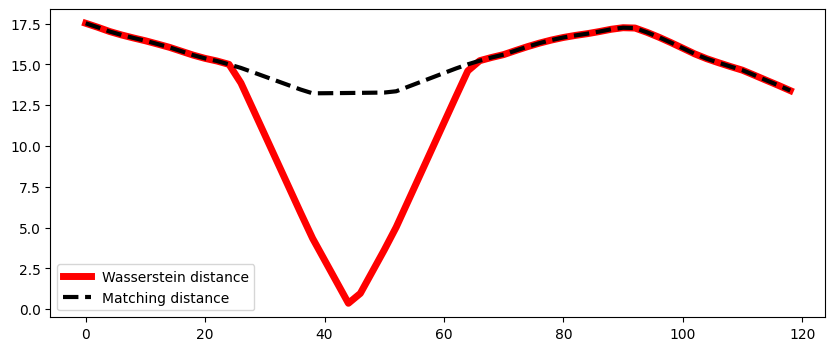

In [42]:
fig, ax = plt.subplots(figsize=(10,4))
indices = np.array(range(len(wasserstein_distances)))*args.time_delay
ax.plot(indices, wasserstein_distances, color="red", label="Wasserstein distance", linewidth=5)
indices = np.array(range(len(matching_distance)))*args.time_delay
ax.plot(indices, matching_distance, color="black", label="Matching distance", linewidth=3, linestyle="--")
plt.legend()
plt.savefig("plots/wasserstein-matching-three-robots.png")